# Trail Recommendations Based on Trail Statistics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

In [2]:
sns.set(style='white')

## Functions

In [3]:
def random_rider(unique_names, ratings_data, trail_data):
    rider = np.random.choice(unique_names)
    rider_trail_ids = ratings_data.loc[ratings_data.user == rider, ['trail_id']]
    rider_trail_ids = rider_trail_ids.values.flatten()
    rider_trails = trail_data.loc[trail_data.trail_id.isin(rider_trail_ids)]
    return rider_trails

def spec_rider(user, ratings_data, trail_data):
    rider_trail_ids = ratings_data.loc[ratings_data.user == user, ['trail_id']]
    rider_trail_ids = rider_trail_ids.values.flatten()
    rider_trails = trail_data.loc[trail_data.trail_id.isin(rider_trail_ids)]
    return rider_trails

def rider_recs(sim_matrix, user_df, trails_df):
    ids = user_df['trail_id'].values
    
    #filtering the similarity values to the users trailset
    sim_rider = sim_matrix.loc[ids, ~sim_matrix.index.isin(ids)]
    
    #using the users trailset to return the top ten trail_id recommendations
    
    trail_recs = sim_rider.mean(axis=0).sort_values(ascending=False).index[0:10]
    
    top_ten_trails = trails_df.loc[trails_df.trail_id.isin(trail_recs)]
    return top_ten_trails

def rider_recs_location(sim_matrix, user_df, trails_df, location):
    ids = user_df['trail_id'].values
    location_filter = trails_df.loc[trails_df.state == location, 'trail_id'].values

    #filtering the similarity values to the users trailset
    mask = (
        (~sim_matrix.index.isin(ids)) &
        (sim_matrix.index.isin(location_filter))
    )
    sim_rider = sim_matrix.loc[ids, mask]

    #using the users trailset to return the top ten trail_id recommendations
    trail_recs = sim_rider.mean(axis=0).sort_values(ascending=False).index[0:10]
    
    top_ten_trails = trails_df.loc[trails_df.trail_id.isin(trail_recs)]
    
    return top_ten_trails

## Data Loading & Prep

In [4]:
df = pd.read_csv('trail_stats_cleaned.csv')
ratings = pd.read_csv('trail_ratings_cleaned.csv')

trail_rating = ratings.groupby('trail_id')['rating'].aggregate(np.mean)
trail_rating = pd.DataFrame(trail_rating)

df = df.merge(trail_rating, left_on='trail_id', right_on=trail_rating.index, how='left')

In [5]:
df.loc[df.rating.isna(), 'rating'] = 0.0
df = df.drop(['climb', 'descent'], axis=1)

print('Number of trails before removing nulls: {}'.format(len(df)))
df.dropna(inplace=True)
print('Number of trails after removing nulls: {}'.format(len(df)))

Number of trails before removing nulls: 59477
Number of trails after removing nulls: 56854


## EDA with Average Trail Ratings

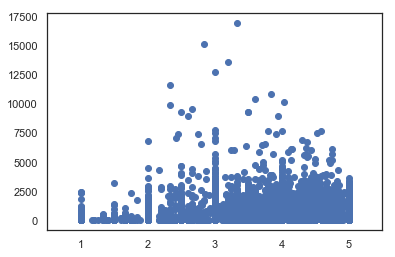

In [6]:
plt.scatter(df['rating'], df['total_rides'])
plt.xlim(0.5, 5.5)
plt.show()

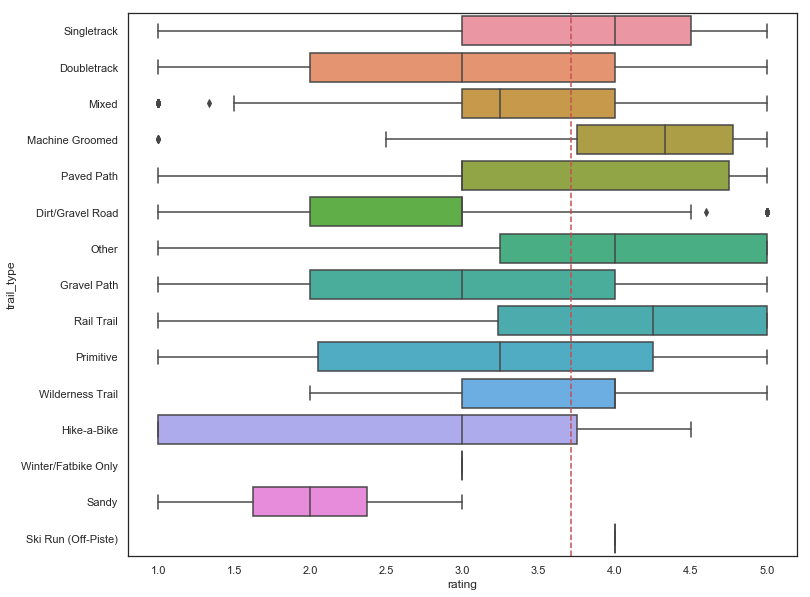

In [7]:
non_zero_rating = df.loc[df.rating > 0]
plt.figure(figsize=(12,10))
sns.boxplot(
    x='rating',
    y='trail_type',
    data=non_zero_rating
)
plt.axvline(non_zero_rating['rating'].mean(), c='r', ls='--')
plt.show()

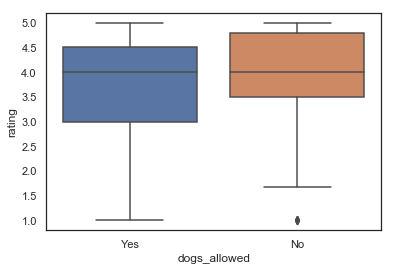

In [8]:
sns.boxplot(
    x='dogs_allowed',
    y='rating',
    data=non_zero_rating
)
plt.show()

## Pipeline for Features and Vectorization

In [9]:
trail_cat_cols = []
for col in df.select_dtypes(include='object').columns:
    if col != 'trail_id' and col != 'trail_name' and col != 'description':
        trail_cat_cols.append(col)

In [10]:
#creating blank array the same size as df, to concatentate labelbinarizer values
cats_transformed = np.empty([len(df), 1])
for col in trail_cat_cols:
    enc = LabelBinarizer().fit_transform(df[col])
    cats_transformed = np.concatenate([cats_transformed, enc], axis=1)

#removing the first column which is generated in the np.empty statement
cats_transformed = cats_transformed[:,1::1]

In [11]:
vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.4,
    stop_words='english',
    use_idf=True,
    smooth_idf=True
)
tfidf_features = vectorizer.fit_transform(df['description']).toarray()
len(tfidf_features[0])

4178

In [12]:
numerical = df.select_dtypes(include='number')
numerical = numerical.drop(['rating'], axis=1)
numerical = numerical.to_numpy()

In [13]:
all_features = np.concatenate([tfidf_features, cats_transformed, numerical], axis=1)
len(all_features[0])

11730

## Similarity Calculation

In [14]:
#cosine similarity takes ~30 minutes to run and is very memory intensive (~600 MB)
#this can only be run once per kernel due to memory requirements
sim = cosine_similarity(all_features)
trail_sim = pd.DataFrame(sim, index=df.trail_id, columns=df.trail_id)

In [ ]:
# this killed the kernel
# maybe it would be better to save to postgres and then query users trail_ids
# to build rec?

#trail_sim.to_json('content_based_cosine_sim.json', orient='records')

## Global Recommendations

For these examples I am using the same user that I used to test the colaborative filtering model. The hope is that we can compare and contrast some of the recommended trails from the two methods.

In [15]:
rider_recs(trail_sim, spec_rider('wisemtnbkr', ratings, df), df)

,trail_id,trail_name,city,state,riding_area,trail_type,total_rides,difficulty_value,difficulty_symbol,dogs_allowed,...,altitude_change,altitude_start,altitude_end,altitude_max,altitude_min,grade,grade_max,grade_min,description,rating
5133,trail_11058,BST (North Ogden),Ogden,Utah,Ogden,Singletrack,956.0,Easy,Green Circe,Yes,...,113.0,5105.0,5217.0,5105.0,5105.0,3.233,-26.772,48.412,Sweet piece of single track starts here.,3.5
13072,trail_13664,Fourmile Link,Boulder,Colorado,Betasso Preserve,Singletrack,704.0,Intermediate,Blue Square,Yes,...,12.0,6276.0,6288.0,6295.0,6145.0,0.289,-34.355,29.250,Trail trail is a bi-directional link from Four...,4.5
13101,trail_16351,Fort Valley (S),Flagstaff,Arizona,Flagstaff,Singletrack,488.0,Easy,Green Circe,Yes,...,-10.0,7249.0,7239.0,7260.0,7224.0,-0.207,-7.464,7.603,No Description,2.0
19066,trail_36567,Le Croy - Dalton Connector,Fayetteville,West Virginia,Arrowhead Trails,Singletrack,209.0,Intermediate,Blue Square,Yes,...,4.0,1898.0,1902.0,1902.0,1868.0,0.308,-18.384,10.551,A short connector between,4.0
24993,trail_116444,Orange Crush Flow,Athens,Georgia,Trail Creek Park,Singletrack,171.0,Intermediate,Blue Square,Yes,...,-15.0,779.0,764.0,779.0,751.0,-2.788,-20.106,9.756,No Description,0.0
27527,trail_118322,PTH Middle Loop,Hinesburg,Vermont,Hinesburg Town Forest,Singletrack,166.0,Very Difficult,Black Diamond,Yes,...,-4.0,1271.0,1267.0,1310.0,1267.0,-0.384,-18.329,14.881,No Description,0.0
32875,trail_110284,South Upper Ext,Bentonville,Arkansas,Blowing Springs,Singletrack,210.0,Intermediate,Blue Square,Yes,...,-15.0,1152.0,1137.0,1159.0,1137.0,-1.893,-16.461,9.314,No Description,3.5
36684,trail_125143,Treadstone (Prayer Flags),Eagle Mountain,Utah,Mountain Ranch Bike Park,Singletrack,458.0,Intermediate,Blue Square,Yes,...,-7.0,5330.0,5323.0,5350.0,5318.0,-0.186,-11.159,11.097,No Description,4.0
41042,trail_122636,Zippity,Fruita,Colorado,18 Road,Singletrack,380.0,Intermediate,Blue Square,Yes,...,-8.0,5101.0,5094.0,5102.0,5027.0,-0.213,-10.848,10.484,Connector trail that is part of the popular Zi...,0.0
54470,trail_116446,Drive by Truckers (Expert),Athens,Georgia,Trail Creek Park,Singletrack,150.0,Very Difficult,Black Diamond,Yes,...,-5.0,759.0,754.0,770.0,742.0,-0.929,-20.224,13.512,No Description,0.0


## Location Recommendations

In [16]:
rider_recs_location(trail_sim, spec_rider('wisemtnbkr', ratings, df), df, 'Utah')

,trail_id,trail_name,city,state,riding_area,trail_type,total_rides,difficulty_value,difficulty_symbol,dogs_allowed,...,altitude_change,altitude_start,altitude_end,altitude_max,altitude_min,grade,grade_max,grade_min,description,rating
1563,trail_9492,Area 51,Orem,Utah,Utah Valley,Singletrack,129.0,Very Difficult,Black Diamond,Yes,...,58.0,6363.0,6422.0,6560.0,6359.0,1.351000,-59.250,72.164,A good drop out connect with nice spots. A dif...,3.500000
5086,trail_11139,BST (22nd to 27th),Ogden,Utah,Ogden,Singletrack,434.0,Easy,Green Circe,Yes,...,-4.0,4843.0,4839.0,4853.0,4823.0,-0.099000,-46.491,50.965,"Easy spin from the 27th street access point, m...",3.000000
5133,trail_11058,BST (North Ogden),Ogden,Utah,Ogden,Singletrack,956.0,Easy,Green Circe,Yes,...,113.0,5105.0,5217.0,5105.0,5105.0,3.233000,-26.772,48.412,Sweet piece of single track starts here.,3.500000
19876,trail_10749,Logan River,Logan,Utah,Logan,Singletrack,418.0,Easy,Green Circe,Yes,...,-69.0,4750.0,4681.0,4766.0,4681.0,-2.383000,-34.451,27.470,No Description,0.000000
29209,trail_9153,Rim Rock Loop,St. George,Utah,Santa Clara River Reserve,Singletrack,426.0,Intermediate,Blue Square,Yes,...,13.0,3395.0,3408.0,3395.0,3395.0,0.614000,-44.682,30.581,"Great loop, good technical sections, flowy",4.000000
34995,trail_9272,The Gap,St. George,Utah,Snow Canyon State Park,Singletrack,65.0,Intermediate,Blue Square,Yes,...,-35.0,3085.0,3050.0,3085.0,3048.0,-1.716000,-22.640,22.200,Nice connector,0.000000
36684,trail_125143,Treadstone (Prayer Flags),Eagle Mountain,Utah,Mountain Ranch Bike Park,Singletrack,458.0,Intermediate,Blue Square,Yes,...,-7.0,5330.0,5323.0,5350.0,5318.0,-0.186000,-11.159,11.097,No Description,4.000000
41081,trail_18555,Zoltar,Moab,Utah,Klonzo,Singletrack,419.0,Intermediate,Blue Square,Yes,...,-13.0,4611.0,4598.0,4611.0,4576.0,-0.382916,-16.663,14.812,No Description,4.166667
55302,trail_125142,Cougar Tracks (Treadstone),Eagle Mountain,Utah,Mountain Ranch Bike Park,Singletrack,586.0,Intermediate,Blue Square,Yes,...,35.0,5297.0,5332.0,5332.0,5273.0,1.099000,-9.767,11.165,Nice easy roll with mostly up and down. You ca...,4.000000
57006,trail_11155,BST (Jump Off),Ogden,Utah,Ogden,Singletrack,961.0,Intermediate,Blue Square,Yes,...,-21.0,4844.0,4823.0,4895.0,4823.0,-0.539000,-66.516,74.943,"Starts out easy, then suddenly turns really te...",2.666667


## Discussion & Conclusions

The content based filtering for all locations recommended 4 out of the top 10 trails in the top 2 most common states that the user rated. It is very interesting that the recommendations are so different than the colaborative approach. Potentially a neural net approach to the colaborative filtering could yield similar results to the content based filtering considering it assumes there are certain unknown factors that make up trails that users ride.

I think the best approach would be to combine the two filtering methods to produce a trailset that is inclusive of trails without a percieved user interaction. This could be done by simple trail rec substitution based on ceratain parameters (i.e. has a rating or not, total ride count, etc.), or on a more complicated weights systemm at the time of recommendation requests.